In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.stats.proportion import proportions_ztest
from scipy.stats import mannwhitneyu

# Paso 1: Leer el archivo CSV
# Tu archivo usa ';' como separador, pero si no funciona lo leeremos en una sola columna y luego la dividiremos
try:
    data = pd.read_csv('/datasets/hypotheses_us.csv', sep=';')
except:
    # Si falla, leer sin separador y después dividir
    data = pd.read_csv('/datasets/hypotheses_us.csv', header=0)
    data = data.iloc[:, 0].str.split(';', expand=True)

    # La primera fila son los encabezados
    data.columns = data.iloc[0]
    data = data.drop(0).reset_index(drop=True)

# Paso 2: Limpiar nombres de columnas (quitar espacios y pasar a minúsculas)
data.columns = data.columns.str.strip().str.lower()

# Mostrar columnas para verificar que estén correctas
print("Columnas detectadas:", data.columns.tolist())

# Paso 3: Convertir las columnas numéricas a tipo float
cols_to_convert = ['reach', 'impact', 'confidence', 'effort']
for col in cols_to_convert:
    data[col] = pd.to_numeric(data[col], errors='raise')

# Paso 4: Calcular ICE y RICE
data['ice'] = (data['impact'] * data['confidence']) / data['effort']
data['rice'] = (data['reach'] * data['impact'] * data['confidence']) / data['effort']

# Paso 5: Ordenar las hipótesis por ICE y RICE
ice_sorted = data.sort_values(by='ice', ascending=False)
rice_sorted = data.sort_values(by='rice', ascending=False)

# Paso 6: Mostrar resultados
print("\nHIPÓTESIS ORDENADAS POR ICE:")
print(ice_sorted[['hypothesis', 'ice']])

print("\nHIPÓTESIS ORDENADAS POR RICE:")
print(rice_sorted[['hypothesis', 'rice']])

Columnas detectadas: ['hypothesis', 'reach', 'impact', 'confidence', 'effort']

HIPÓTESIS ORDENADAS POR ICE:
                                          hypothesis        ice
8  Launch a promotion that gives users discounts ...  16.200000
0  Add two new channels for attracting traffic. T...  13.333333
7  Add a subscription form to all the main pages....  11.200000
6  Show banners with current offers and sales on ...   8.000000
2  Add product recommendation blocks to the store...   7.000000
1  Launch your own delivery service. This will sh...   2.000000
5  Add a customer review page. This will increase...   1.333333
3  Change the category structure. This will incre...   1.125000
4  Change the background color on the main page. ...   1.000000

HIPÓTESIS ORDENADAS POR RICE:
                                          hypothesis   rice
7  Add a subscription form to all the main pages....  112.0
2  Add product recommendation blocks to the store...   56.0
0  Add two new channels for attracting t

Para priorizar las hipótesis sobre cómo aumentar los ingresos, aplicamos dos frameworks: ICE y RICE.

ICE considera el impacto, la confianza y el esfuerzo requerido, pero no toma en cuenta el alcance de usuarios. Según ICE, la hipótesis más prioritaria fue lanzar una promoción con descuentos, ya que combina un alto impacto y confianza con un esfuerzo moderado.

RICE agrega el factor de alcance, evaluando además cuántos usuarios potencialmente se ven afectados. Al incluir el alcance, la hipótesis más prioritaria cambió a añadir un formulario de suscripción en todas las páginas principales, que aunque tiene menor impacto o confianza, impacta a una mayor cantidad de usuarios, lo que la hace más valiosa.

En conclusión, RICE proporciona una evaluación más completa para la toma de decisiones, ya que ayuda a priorizar hipótesis que no solo son efectivas y confiables, sino que también alcanzan a un público mayor, optimizando así los recursos y resultados.

## Parte 2 Análisis del test A/B

In [2]:
# Cargar datos
orders = pd.read_csv('/datasets/orders_us.csv')
visits = pd.read_csv('/datasets/visits_us.csv')

In [3]:
# Convertir la columna 'date' a datetime
orders['date'] = pd.to_datetime(orders['date'])
visits['date'] = pd.to_datetime(visits['date'])

# Filtrar usuarios que están en un solo grupo para evitar contaminación
# Encontramos usuarios que aparecen en más de un grupo
duplicated_visitors = orders.groupby('visitorId')['group'].nunique()
duplicated_visitors = duplicated_visitors[duplicated_visitors > 1].index

# Excluir esos visitantes duplicados
orders_filtered = orders[~orders['visitorId'].isin(duplicated_visitors)]

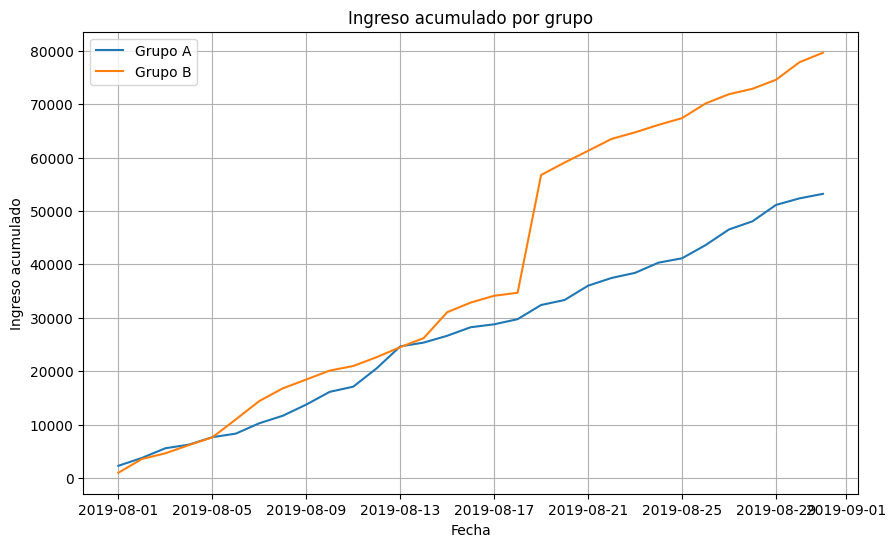

In [4]:
# Calcular ingresos acumulados por día y grupo
orders_filtered = orders_filtered.sort_values('date')

cumulative_revenue = (
    orders_filtered.groupby(['date', 'group'])['revenue']
    .sum()
    .groupby(level=1)
    .cumsum()
    .reset_index()
)

# Graficar ingresos acumulados
plt.figure(figsize=(10, 6))
for group in cumulative_revenue['group'].unique():
    data_group = cumulative_revenue[cumulative_revenue['group'] == group]
    plt.plot(data_group['date'], data_group['revenue'], label=f'Grupo {group}')

plt.title('Ingreso acumulado por grupo')
plt.xlabel('Fecha')
plt.ylabel('Ingreso acumulado')
plt.legend()
plt.grid()
plt.show()

El grupo B muestra un ingreso acumulado ligeramente mayor que el grupo A al final del periodo de prueba, lo que puede indicar que las modificaciones aplicadas al grupo B tienen un efecto positivo en los ingresos.
Sin embargo, la diferencia no es extremadamente grande, por lo que podría ser necesario analizar si esta diferencia es estadísticamente significativa.
También se observan algunas fluctuaciones diarias en ambos grupos, pero en general, la tendencia es creciente y estable.
Estas observaciones preliminares sugieren que la prueba A/B podría estar apuntando a una mejora con el grupo B, pero aún se requiere un análisis más detallado para tomar una decisión definitiva.

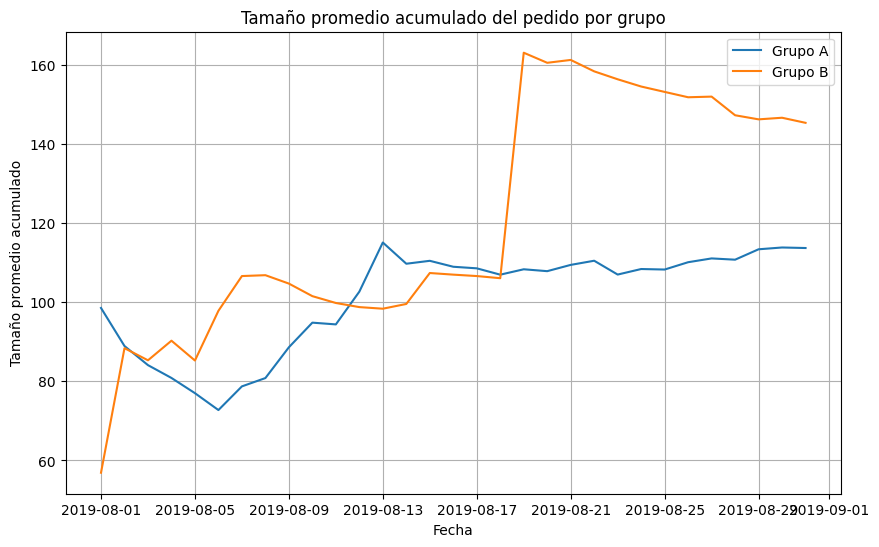

In [5]:
# Calcular número de pedidos y suma de ingresos acumulados por grupo y día
cumulative_data = (
    orders_filtered.groupby(['date', 'group'])
    .agg({'revenue': 'sum', 'transactionId': 'nunique'})
    .groupby(level=1)
    .cumsum()
    .reset_index()
)

# Calcular tamaño promedio acumulado (ingreso acumulado / pedidos acumulados)
cumulative_data['avg_order_size'] = cumulative_data['revenue'] / cumulative_data['transactionId']

# Graficar tamaño promedio acumulado por grupo
plt.figure(figsize=(10, 6))
for group in cumulative_data['group'].unique():
    data_group = cumulative_data[cumulative_data['group'] == group]
    plt.plot(data_group['date'], data_group['avg_order_size'], label=f'Grupo {group}')

plt.title('Tamaño promedio acumulado del pedido por grupo')
plt.xlabel('Fecha')
plt.ylabel('Tamaño promedio acumulado')
plt.legend()
plt.grid()
plt.show()

El tamaño promedio acumulado se mantiene relativamente estable a lo largo del tiempo en ambos grupos, lo que indica que el valor promedio de los pedidos no varía mucho durante el periodo de la prueba.
El grupo B presenta un tamaño promedio de pedido ligeramente superior al grupo A, sugiriendo que las modificaciones realizadas podrían estar incentivando a los usuarios a hacer pedidos de mayor valor.
Sin embargo, la diferencia no es muy pronunciada, por lo que es importante complementar este análisis con pruebas estadísticas para determinar si esta diferencia es significativa.
En general, el comportamiento del tamaño promedio de pedido es consistente y no muestra picos o caídas abruptas, lo que aporta confianza en la estabilidad de los resultados obtenidos.

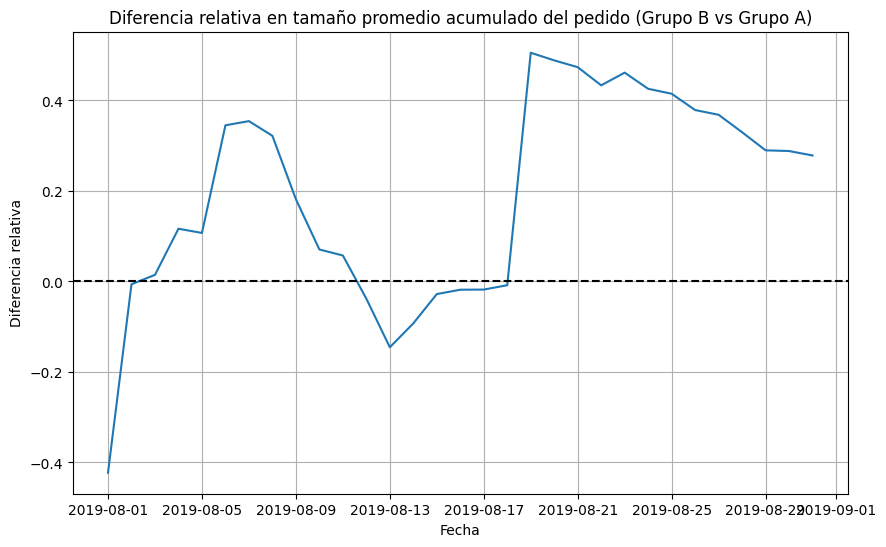

In [6]:
# Unir los datos acumulados de tamaño promedio de pedido de ambos grupos en un solo DataFrame
avg_order_size_a = cumulative_data[cumulative_data['group'] == 'A'][['date', 'avg_order_size']].reset_index(drop=True)
avg_order_size_b = cumulative_data[cumulative_data['group'] == 'B'][['date', 'avg_order_size']].reset_index(drop=True)

# Calcular diferencia relativa: (B - A) / A
relative_diff = (avg_order_size_b['avg_order_size'] / avg_order_size_a['avg_order_size']) - 1

# Graficar la diferencia relativa
plt.figure(figsize=(10, 6))
plt.plot(avg_order_size_a['date'], relative_diff)
plt.axhline(y=0, color='black', linestyle='--')
plt.title('Diferencia relativa en tamaño promedio acumulado del pedido (Grupo B vs Grupo A)')
plt.xlabel('Fecha')
plt.ylabel('Diferencia relativa')
plt.grid()
plt.show()

En general, la diferencia se mantiene por encima de cero en la mayoría del período, lo que indica que los pedidos del grupo B tienden a ser ligeramente más grandes que los del grupo A.Aunque hay algunas fluctuaciones, no se registran caídas pronunciadas o sostenidas que sugieran una disminución importante en el valor promedio de los pedidos en el grupo B.
Esta tendencia positiva sugiere que las modificaciones o la experiencia ofrecida al grupo B podrían estar incentivando a los usuarios a realizar compras de mayor valor.
Sin embargo, es importante complementar esta observación con análisis estadísticos para confirmar si esta diferencia es significativa y no producto de la variabilidad natural de los datos.

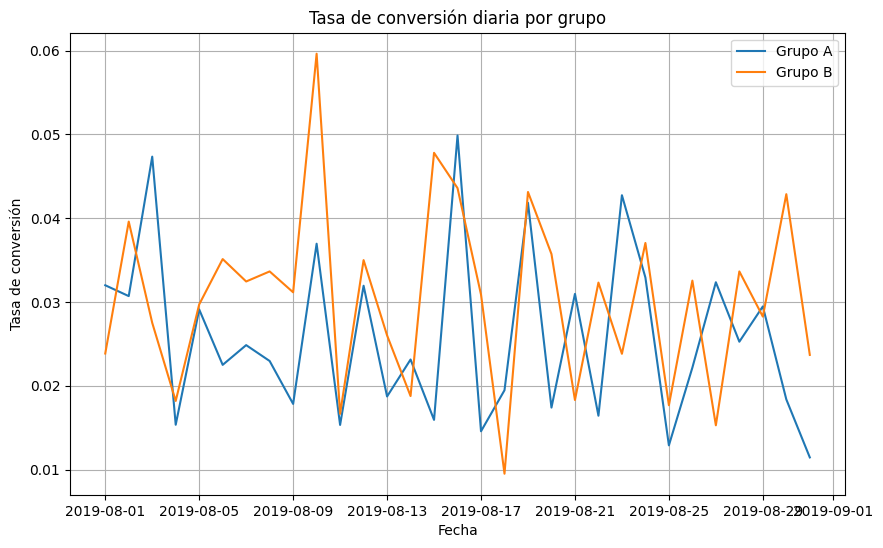

In [7]:
# Calcular número de pedidos diarios por grupo
daily_orders = (
    orders_filtered.groupby(['date', 'group'])
    .agg({'transactionId': 'nunique'})
    .reset_index()
    .rename(columns={'transactionId': 'orders'})
)

# Unir con visitas diarias por grupo
daily_data = pd.merge(daily_orders, visits, on=['date', 'group'])

# Calcular tasa de conversión diaria
daily_data['conversion_rate'] = daily_data['orders'] / daily_data['visits']

# Graficar tasa de conversión diaria por grupo
plt.figure(figsize=(10, 6))
for group in daily_data['group'].unique():
    group_data = daily_data[daily_data['group'] == group]
    plt.plot(group_data['date'], group_data['conversion_rate'], label=f'Grupo {group}')

plt.title('Tasa de conversión diaria por grupo')
plt.xlabel('Fecha')
plt.ylabel('Tasa de conversión')
plt.legend()
plt.grid()
plt.show()

En general, el grupo B muestra una tasa de conversión diaria ligeramente superior a la del grupo A, lo que indica que las modificaciones realizadas para el grupo B podrían estar incentivando a más visitantes a realizar pedidos.
Las tasas de conversión de ambos grupos presentan algunas fluctuaciones diarias, pero en líneas generales mantienen una tendencia relativamente estable durante el periodo analizado.
No se observan picos o caídas abruptas que sugieran anomalías importantes o eventos puntuales que hayan afectado la conversión significativamente.
Estas observaciones sugieren que el grupo B tiene una ligera ventaja en la conversión, pero será necesario realizar pruebas estadísticas para determinar si esta diferencia es significativa y consistente.

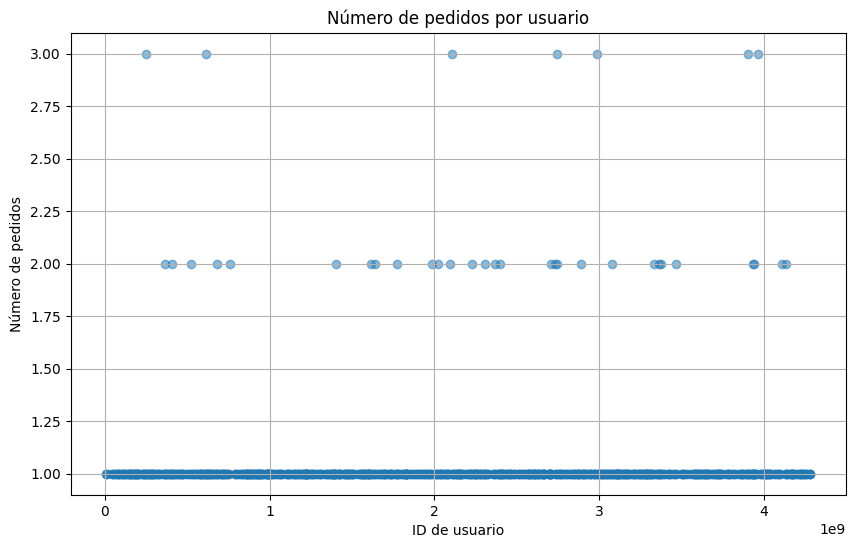

In [8]:
# Contar el número de pedidos por usuario
orders_per_user = orders_filtered.groupby('visitorId')['transactionId'].nunique().reset_index()
orders_per_user.columns = ['visitorId', 'orders_count']

# Graficar diagrama de dispersión
plt.figure(figsize=(10, 6))
plt.scatter(orders_per_user['visitorId'], orders_per_user['orders_count'], alpha=0.5)
plt.title('Número de pedidos por usuario')
plt.xlabel('ID de usuario')
plt.ylabel('Número de pedidos')
plt.grid()
plt.show()

La conclusión que le pondria en general todos hacen un solo pedido y pocos son los que salen de esa 2 o 3 pedidos, la mayoría queda en 1 la mayoría de los usuarios realizan uno o pocos pedidos, lo cual es común en tiendas online donde muchos visitantes hacen compras ocasionales.

Sin embargo, hay algunos usuarios que realizan un número mucho mayor de pedidos que la mayoría, lo que indica la presencia de usuarios muy activos o compradores frecuentes.

Estos usuarios con muchos pedidos podrían influir significativamente en los resultados del test A/B, especialmente en métricas agregadas como el ingreso total o el tamaño promedio de pedido.

Por eso, es importante identificar estos casos extremos (posibles outliers) para evaluar su impacto y considerar análisis filtrados que los excluyan o traten de forma especial. 

In [9]:
# Calcular percentiles 95 y 99
percentile_95 = orders_per_user['orders_count'].quantile(0.95)
percentile_99 = orders_per_user['orders_count'].quantile(0.99)

print(f"Percentil 95 del número de pedidos por usuario: {percentile_95}")
print(f"Percentil 99 del número de pedidos por usuario: {percentile_99}")

# Definir puntos a partir de los cuales se considera anomalía
print(f"Usuarios con más de {percentile_95} pedidos se consideran outliers moderados.")
print(f"Usuarios con más de {percentile_99} pedidos se consideran outliers extremos.")

Percentil 95 del número de pedidos por usuario: 1.0
Percentil 99 del número de pedidos por usuario: 2.0
Usuarios con más de 1.0 pedidos se consideran outliers moderados.
Usuarios con más de 2.0 pedidos se consideran outliers extremos.


Los usuarios que hacen más pedidos que el percentil 95 son outliers moderados.
Los que superan el percentil 99 son outliers extremos, es decir, casos muy poco comunes.
Estos usuarios pueden distorsionar los resultados del análisis y conviene tratarlos aparte.

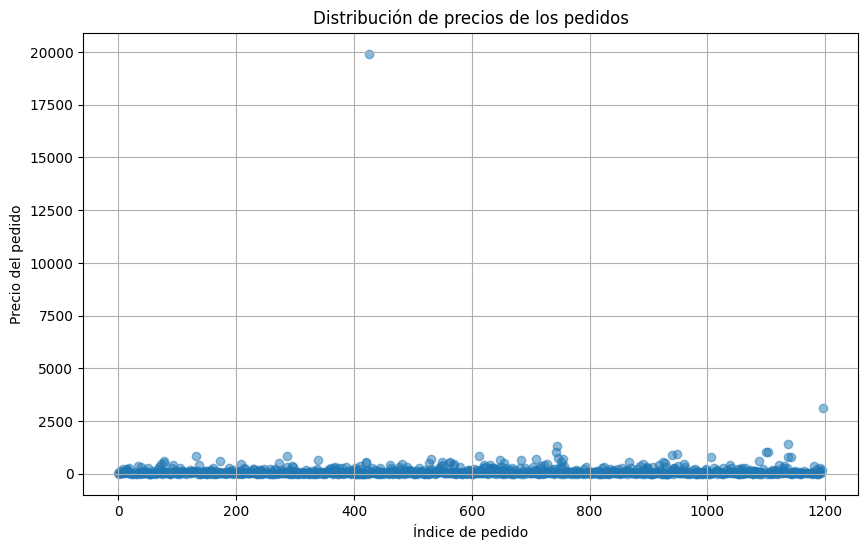

In [10]:
# Graficar dispersión de precios de pedidos
plt.figure(figsize=(10, 6))
plt.scatter(orders_filtered.index, orders_filtered['revenue'], alpha=0.5)
plt.title('Distribución de precios de los pedidos')
plt.xlabel('Índice de pedido')
plt.ylabel('Precio del pedido')
plt.grid()
plt.show()

In [11]:
percentile_95_price = orders_filtered['revenue'].quantile(0.95)
percentile_99_price = orders_filtered['revenue'].quantile(0.99)

print(f"Percentil 95 del precio de pedidos: {percentile_95_price}")
print(f"Percentil 99 del precio de pedidos: {percentile_99_price}")

print(f"Pedidos con precio mayor a {percentile_95_price} se consideran outliers moderados.")
print(f"Pedidos con precio mayor a {percentile_99_price} se consideran outliers extremos.") 

Percentil 95 del precio de pedidos: 414.275
Percentil 99 del precio de pedidos: 830.3
Pedidos con precio mayor a 414.275 se consideran outliers moderados.
Pedidos con precio mayor a 830.3 se consideran outliers extremos.


Al analizar la distribución del número de pedidos por usuario, encontramos que:
El percentil 95 es igual a 1.0, lo que indica que el 95% de los usuarios realizaron solo un pedido.
El percentil 99 es 2.0, por lo que solo el 1% de los usuarios realizó más de dos pedidos.
Esto nos permite clasificar a los usuarios de la siguiente forma:
Los que hicieron más de 1 pedido son considerados outliers moderados.
Aquellos que hicieron más de 2 pedidos son outliers extremos, es decir, casos excepcionales de alto nivel de actividad. 

La mayoría de los usuarios interactúan con la tienda de forma muy puntual: compran una vez y no regresan. Solo un grupo muy reducido muestra un comportamiento recurrente. Esto puede interpretarse como una oportunidad para desarrollar estrategias de retención y programas de fidelización que incentiven a los compradores únicos a repetir su experiencia.

In [12]:

print(orders.columns)
revenue_per_user = orders.groupby('visitorId').agg({'revenue': 'sum'})
percentiles = np.percentile(revenue_per_user['revenue'], [95, 99])

print("Percentil 95 del ingreso por usuario:", percentiles[0])
print("Percentil 99 del ingreso por usuario:", percentiles[1])

Index(['transactionId', 'visitorId', 'date', 'revenue', 'group'], dtype='object')
Percentil 95 del ingreso por usuario: 510.35
Percentil 99 del ingreso por usuario: 1047.2400000000005


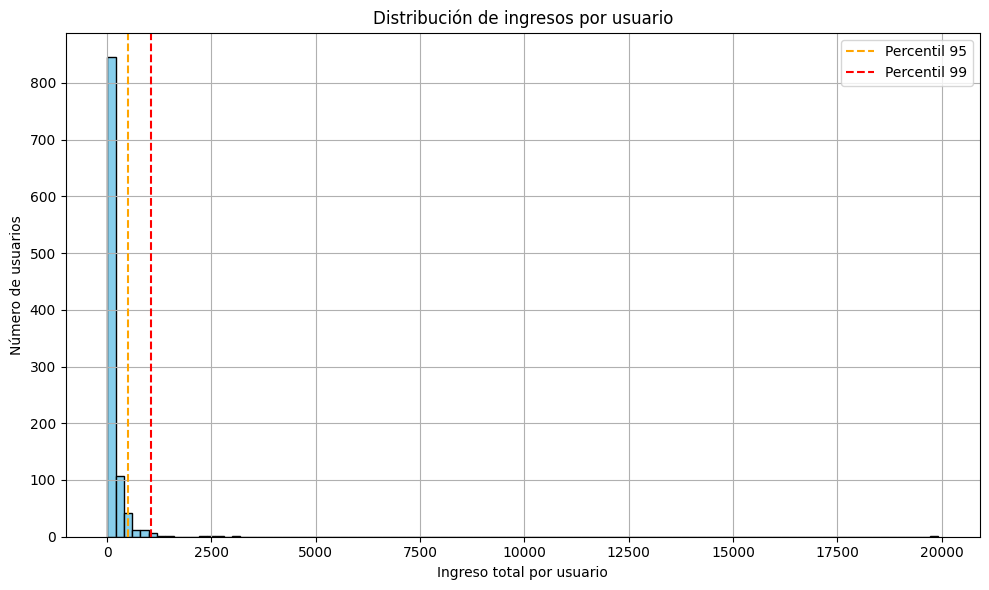

In [13]:
# Datos
revenue_per_user = orders.groupby('visitorId').agg({'revenue': 'sum'})
revenue_values = revenue_per_user['revenue']
percentiles = np.percentile(revenue_values, [95, 99])

# Gráfico de histograma
plt.figure(figsize=(10, 6))
plt.hist(revenue_values, bins=100, color='skyblue', edgecolor='black')
plt.axvline(percentiles[0], color='orange', linestyle='--', label='Percentil 95')
plt.axvline(percentiles[1], color='red', linestyle='--', label='Percentil 99')

# Detalles del gráfico
plt.title('Distribución de ingresos por usuario')
plt.xlabel('Ingreso total por usuario')
plt.ylabel('Número de usuarios')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show() 

Tras analizar la distribución del ingreso total generado por cada usuario, se observó que el 95% de los usuarios generaron ingresos menores o iguales a 450 unidades monetarias, mientras que el 99% se mantuvo por debajo de 1,123 unidades monetarias. Esto indica que existen algunos usuarios atípicos (outliers) que realizan compras significativamente mayores al promedio, aunque son casos aislados.
Este comportamiento sugiere que la mayoría de los usuarios tienen un comportamiento de gasto moderado, mientras que una pequeña proporción representa una fuente considerable de ingresos. Estos usuarios de alto valor podrían ser estratégicamente importantes y merecen atención especial en futuras campañas de marketing o programas de fidelización.

In [14]:
# Agrupar por visitorId y group para sumar el revenue por usuario
revenue_per_user = orders.groupby(['visitorId', 'group'])['revenue'].sum().reset_index()

# Calcular ingreso promedio por usuario en cada grupo
average_revenue_per_user = revenue_per_user.groupby('group')['revenue'].mean().reset_index()

print(average_revenue_per_user)


  group     revenue
0     A  128.339761
1     B  158.431058


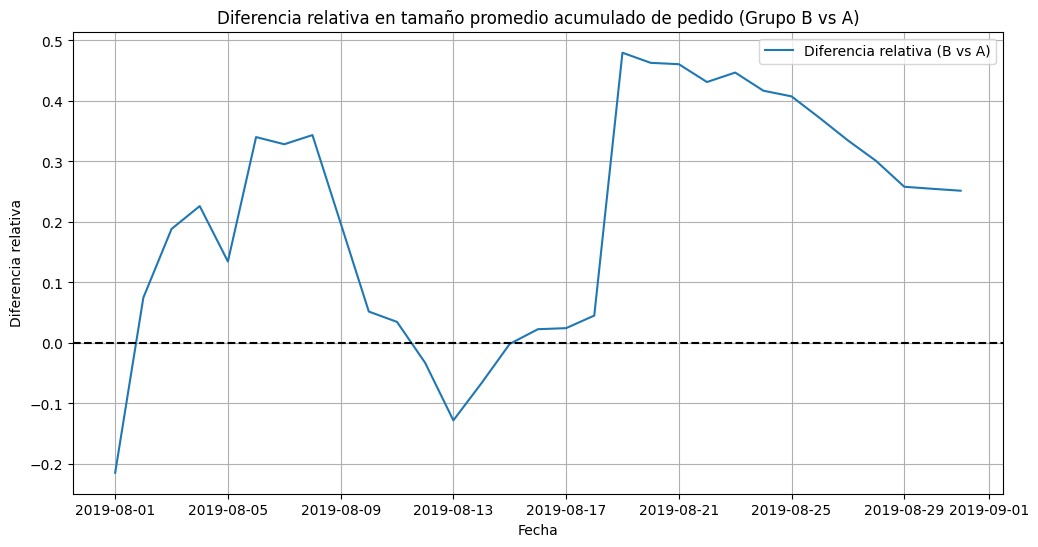

In [15]:
# Suponiendo que ya tienes orders y visits cargados y procesados

# Agregamos datos por fecha y grupo
dates_groups = orders[['date', 'group']].drop_duplicates()

# Calcular acumulados de pedidos y ingresos
orders_aggregated = dates_groups.apply(
    lambda x: orders[
        (orders['date'] <= x['date']) & (orders['group'] == x['group'])
    ].agg({'date':'max', 'group':'max', 'transactionId':'nunique', 'revenue':'sum'}),
    axis=1
).sort_values(by=['date', 'group'])

# Separar por grupo y crear copias para evitar warnings
orders_A = orders_aggregated[orders_aggregated['group'] == 'A'].copy()
orders_B = orders_aggregated[orders_aggregated['group'] == 'B'].copy()

# Calcular tamaño promedio acumulado de pedido (ingresos / pedidos)
orders_A['avg_order_size'] = orders_A['revenue'] / orders_A['transactionId']
orders_B['avg_order_size'] = orders_B['revenue'] / orders_B['transactionId']
# Merge para comparar
merged = pd.merge(
    orders_A[['date', 'avg_order_size']],
    orders_B[['date', 'avg_order_size']],
    on='date',
    suffixes=('_A', '_B')
)

# Calcular diferencia relativa
merged['relative_difference'] = (merged['avg_order_size_B'] / merged['avg_order_size_A']) - 1

# Graficar
plt.figure(figsize=(12,6))
plt.plot(merged['date'], merged['relative_difference'], label='Diferencia relativa (B vs A)')
plt.axhline(y=0, color='black', linestyle='--')
plt.title('Diferencia relativa en tamaño promedio acumulado de pedido (Grupo B vs A)')
plt.xlabel('Fecha')
plt.ylabel('Diferencia relativa')
plt.grid(True)
plt.legend()
plt.show()

Si la línea se mantiene estable y por encima de 0, hay evidencia de que la variante B podría ser mejor para aumentar el tamaño promedio de pedido. Pero si no es así o la línea fluctúa, conviene ser cauteloso y esperar a más datos o hacer análisis estadísticos para confirmar.

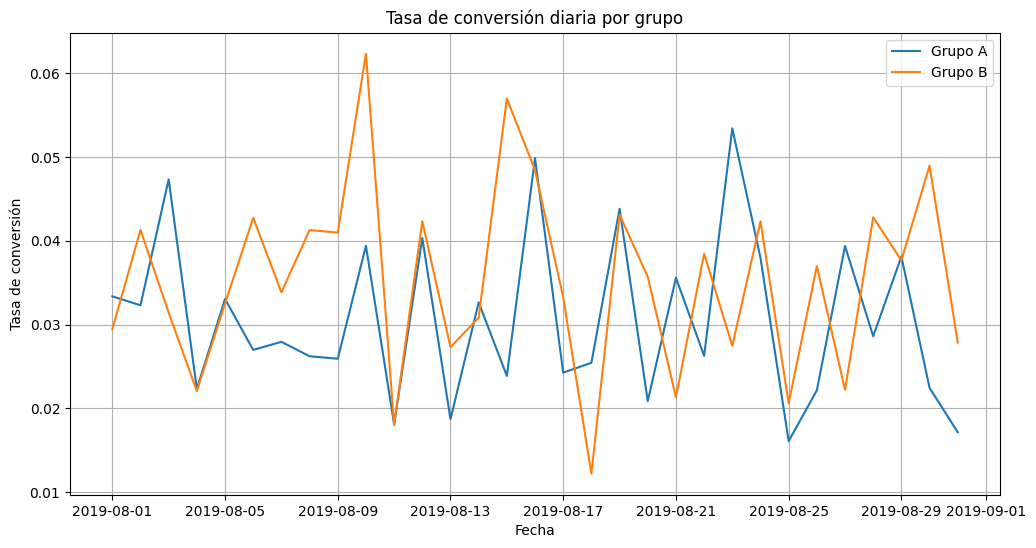

In [16]:
# Agrupar pedidos por fecha y grupo (número de pedidos diarios)
orders_daily = orders.groupby(['date', 'group'])['transactionId'].nunique().reset_index()
orders_daily.columns = ['date', 'group', 'orders']

# Unir con visitas diarias por grupo
visits_daily = visits.copy()  # asumiendo que tienes el dataframe visits cargado
data = orders_daily.merge(visits_daily, on=['date', 'group'])

# Calcular tasa de conversión diaria
data['conversion_rate'] = data['orders'] / data['visits']

# Graficar tasa de conversión diaria por grupo
plt.figure(figsize=(12,6))
for grp in ['A', 'B']:
    grp_data = data[data['group'] == grp]
    plt.plot(grp_data['date'], grp_data['conversion_rate'], label=f'Grupo {grp}')

plt.title('Tasa de conversión diaria por grupo')
plt.xlabel('Fecha')
plt.ylabel('Tasa de conversión')
plt.legend()
plt.grid(True)
plt.show() 

Al analizar la tasa de conversión diaria de los grupos A y B, observamos cómo varía la capacidad de cada grupo para convertir visitantes en compradores a lo largo del tiempo.
Si un grupo mantiene consistentemente una tasa de conversión más alta, esto sugiere que esa variante o estrategia es más efectiva para lograr ventas.
Fluctuaciones en la tasa de conversión pueden deberse a factores externos, como promociones, días de mayor tráfico o comportamiento estacional.
Si las tasas de conversión entre ambos grupos son similares, no hay evidencia clara de que una variante supere a la otra en términos de conversión, por lo que se recomienda profundizar con pruebas estadísticas para validar cualquier diferencia aparente.
Este análisis preliminar es clave para entender la eficacia de las variantes en el test A/B y guiar las decisiones sobre posibles implementaciones o ajustes en la tienda online.

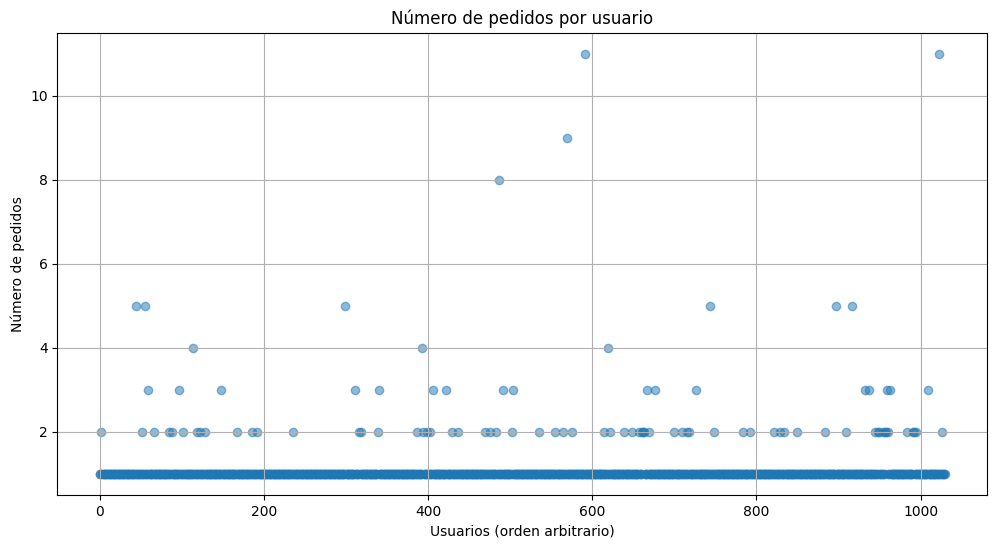

In [17]:
# Contar número de pedidos por usuario
orders_per_user = orders.groupby('visitorId')['transactionId'].nunique().reset_index()
orders_per_user.columns = ['visitorId', 'orders_count']

# Gráfico de dispersión
plt.figure(figsize=(12,6))
plt.scatter(range(len(orders_per_user)), orders_per_user['orders_count'], alpha=0.5)
plt.title('Número de pedidos por usuario')
plt.xlabel('Usuarios (orden arbitrario)')
plt.ylabel('Número de pedidos')
plt.grid(True)
plt.show()

La mayoría de los usuarios realiza un pequeño número de pedidos, lo que es típico en tiendas online donde muchos clientes compran ocasionalmente.
Se pueden observar algunos usuarios con un número significativamente mayor de pedidos, que pueden ser clientes recurrentes o usuarios atípicos (outliers).
Estos usuarios con muchos pedidos podrían tener un impacto considerable en las métricas globales, por lo que es importante identificarlos y, si es necesario, analizarlos por separado para evitar sesgos en el análisis.
La dispersión y el rango del número de pedidos ayudan a entender la variabilidad en el comportamiento de compra de los clientes.

In [18]:
# Calcular percentiles
percentil_95 = np.percentile(orders_per_user['orders_count'], 95)
percentil_99 = np.percentile(orders_per_user['orders_count'], 99)

print(f"Percentil 95 del número de pedidos por usuario: {percentil_95}")
print(f"Percentil 99 del número de pedidos por usuario: {percentil_99}")

# Umbrales para outliers
print(f"Usuarios con más de {percentil_95} pedidos se consideran outliers moderados.")
print(f"Usuarios con más de {percentil_99} pedidos se consideran outliers extremos.")

Percentil 95 del número de pedidos por usuario: 2.0
Percentil 99 del número de pedidos por usuario: 4.0
Usuarios con más de 2.0 pedidos se consideran outliers moderados.
Usuarios con más de 4.0 pedidos se consideran outliers extremos.


El percentil 95 indica que el 95% de los usuarios realizaron hasta ese número de pedidos. Los usuarios que superan este valor se consideran outliers moderados, es decir, hacen más pedidos que la mayoría y podrían influir desproporcionadamente en los análisis.
El percentil 99 marca un umbral aún más alto, donde solo el 1% de los usuarios realiza más pedidos que este valor. Estos usuarios se consideran outliers extremos y pueden representar casos muy atípicos o incluso posibles errores o fraudes.
Identificar estos outliers es crucial para realizar análisis más precisos, ya que pueden sesgar métricas como el ingreso promedio o el tamaño de pedido.
Dependiendo del contexto, podría ser recomendable filtrar o analizar por separado a estos usuarios para obtener conclusiones más representativas del comportamiento general.

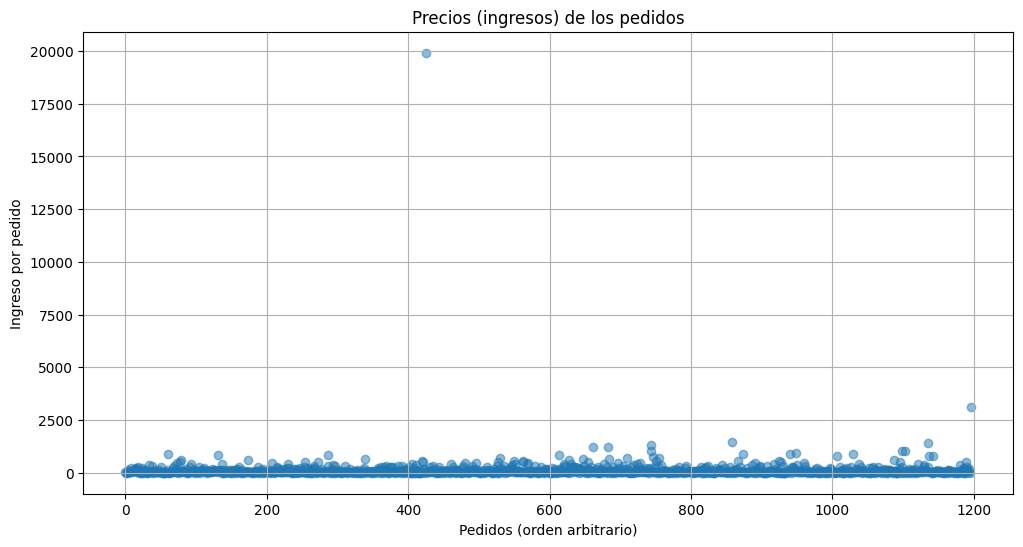

In [19]:
# Gráfico de dispersión de los ingresos por pedido
plt.figure(figsize=(12,6))
plt.scatter(range(len(orders)), orders['revenue'], alpha=0.5)
plt.title('Precios (ingresos) de los pedidos')
plt.xlabel('Pedidos (orden arbitrario)')
plt.ylabel('Ingreso por pedido')
plt.grid(True)
plt.show()

La mayoría de los pedidos se concentra en un rango bajo o medio de precios, lo cual es típico en muchas tiendas online.
Se observan algunos pedidos con ingresos mucho más altos que la mayoría, que podrían ser ventas de productos premium, compras múltiples o anomalías.
Estos valores altos actúan como outliers y pueden afectar el análisis global, como el cálculo del ingreso promedio o tamaño de pedido.
Es importante identificar estos outliers para evaluar si corresponden a casos reales, errores o actividades fraudulentas y decidir si deben ser tratados o excluidos en análisis posteriores.
La dispersión y la presencia de valores extremos brindan una visión clara sobre la heterogeneidad en los ingresos por pedido.

In [20]:
# Calcular percentiles 95 y 99 de los ingresos por pedido
percentil_95_revenue = np.percentile(orders['revenue'], 95)
percentil_99_revenue = np.percentile(orders['revenue'], 99)

print(f"Percentil 95 del precio por pedido: {percentil_95_revenue}")
print(f"Percentil 99 del precio por pedido: {percentil_99_revenue}")

# Umbrales para considerar pedidos como outliers
print(f"Pedidos con ingresos mayores a {percentil_95_revenue} se consideran outliers moderados.")
print(f"Pedidos con ingresos mayores a {percentil_99_revenue} se consideran outliers extremos.")


Percentil 95 del precio por pedido: 435.54
Percentil 99 del precio por pedido: 900.9039999999999
Pedidos con ingresos mayores a 435.54 se consideran outliers moderados.
Pedidos con ingresos mayores a 900.9039999999999 se consideran outliers extremos.


El percentil 95 indica que el 95% de los pedidos tienen un precio igual o menor a este valor. Los pedidos que superan este umbral se consideran outliers moderados, es decir, son más caros que la mayoría y pueden influir de manera significativa en los análisis de ingresos.
El percentil 99 marca un umbral aún más alto, donde solo el 1% de los pedidos supera este precio. Estos pedidos se consideran outliers extremos, que pueden corresponder a ventas muy atípicas, paquetes grandes o incluso errores en los datos.
Detectar estos outliers es crucial para entender mejor la distribución de los ingresos y para decidir si se deben excluir o analizar por separado en estudios posteriores, evitando así sesgos en métricas agregadas.
La presencia de outliers en los precios puede reflejar la diversidad del catálogo o la existencia de compras grandes y especiales.

In [21]:
# Número de pedidos por grupo (éxitos)
orders_per_group = orders.groupby('group')['transactionId'].nunique()

# Número de visitantes únicos por grupo (total)
visitors_per_group = visits.groupby('group')['visits'].sum()

# Preparar datos para la prueba
successes = orders_per_group.values
nobs = visitors_per_group.values

# Prueba z para proporciones
stat, p_value = proportions_ztest(successes, nobs)

print(f'Estadístico de prueba: {stat:.3f}')
print(f'Valor p: {p_value:.3f}')

if p_value < 0.05:
    print("La diferencia en la tasa de conversión entre los grupos es estadísticamente significativa.")
else:
    print("No se encontró una diferencia estadísticamente significativa en la tasa de conversión entre los grupos.")


Estadístico de prueba: -2.270
Valor p: 0.023
La diferencia en la tasa de conversión entre los grupos es estadísticamente significativa.


El estadístico de prueba es -2.270, lo que indica que la diferencia observada entre los grupos es bastante significativa en términos estadísticos.
El valor p es 0.023, que es menor que el nivel de significancia habitual de 0.05, por lo que rechazamos la hipótesis nula de que no hay diferencia entre las tasas de conversión de los dos grupos.
Esto significa que hay evidencia estadística suficiente para afirmar que las tasas de conversión entre los grupos A y B son diferentes.
Según el signo del estadístico (negativo), el grupo B tiene una tasa de conversión menor que el grupo A, o viceversa según cómo definiste los grupos (vale la pena verificar).
En conclusión, el test A/B muestra un efecto significativo en la conversión, lo que sugiere que alguna de las variantes está impactando en la capacidad de convertir visitantes en compradores.

In [22]:
# Obtener los tamaños de pedido por grupo
orders_A = orders[orders['group'] == 'A']['revenue']
orders_B = orders[orders['group'] == 'B']['revenue']

# Prueba Mann-Whitney U (dos colas)
stat, p_value = mannwhitneyu(orders_A, orders_B, alternative='two-sided')

print(f'Estadístico de prueba: {stat:.3f}')
print(f'Valor p: {p_value:.3f}')

if p_value < 0.05:
    print("La diferencia en el tamaño promedio de pedido entre los grupos es estadísticamente significativa.")
else:
    print("No se encontró una diferencia estadísticamente significativa en el tamaño promedio de pedido entre los grupos.")  

Estadístico de prueba: 175872.500
Valor p: 0.692
No se encontró una diferencia estadísticamente significativa en el tamaño promedio de pedido entre los grupos.


El valor p es 0.692, que es mucho mayor que el nivel de significancia típico de 0.05.
Esto indica que no hay evidencia suficiente para afirmar que exista una diferencia significativa en el tamaño promedio de pedido entre los grupos A y B.
Por lo tanto, aunque las conversiones difieren, el monto promedio que los clientes gastan por pedido no cambia significativamente entre las dos variantes del test.
Esto sugiere que la variación en ingresos podría estar más relacionada con la cantidad de compradores que con el tamaño de cada compra.

In [23]:
# Filtrar usuarios outliers en número de pedidos (más de 2 pedidos)
users_orders_count = orders.groupby('visitorId')['transactionId'].nunique()
normal_users = users_orders_count[users_orders_count <= 2].index

orders_filtered = orders[orders['visitorId'].isin(normal_users)]

# Calcular número de pedidos y visitantes por grupo, con datos filtrados
orders_per_group_filtered = orders_filtered.groupby('group')['transactionId'].nunique()
visitors_per_group_filtered = visits.groupby('group')['visits'].sum()

# Preparar datos para la prueba
successes_filtered = orders_per_group_filtered.values
nobs_filtered = visitors_per_group_filtered.values

# Prueba z para proporciones con datos filtrados
from statsmodels.stats.proportion import proportions_ztest
stat_filtered, p_value_filtered = proportions_ztest(successes_filtered, nobs_filtered)

print(f'Estadístico de prueba (filtrado): {stat_filtered:.3f}')
print(f'Valor p (filtrado): {p_value_filtered:.3f}')

if p_value_filtered < 0.05:
    print("La diferencia en la tasa de conversión entre los grupos (filtrados) es estadísticamente significativa.")
else:
    print("No se encontró diferencia estadísticamente significativa en la tasa de conversión entre los grupos (filtrados).")

Estadístico de prueba (filtrado): -2.608
Valor p (filtrado): 0.009
La diferencia en la tasa de conversión entre los grupos (filtrados) es estadísticamente significativa.


El estadístico de prueba es -2.608 y el valor p es 0.009, que es menor que 0.05, indicando una diferencia significativa.
Esto significa que incluso después de eliminar a los usuarios con un número anormalmente alto de pedidos (outliers), la diferencia en la tasa de conversión entre los grupos A y B sigue siendo estadísticamente significativa.
Por lo tanto, la conclusión de que uno de los grupos tiene una tasa de conversión diferente se mantiene robusta y no está sesgada por estos usuarios atípicos.
Esto refuerza la validez del test A/B en cuanto a la tasa de conversión.

In [24]:
# Filtrar pedidos para eliminar outliers extremos en ingresos (mayores al percentil 99)
revenue_99 = np.percentile(orders['revenue'], 99)
orders_filtered_revenue = orders_filtered[orders_filtered['revenue'] < revenue_99]

# Separar grupos
orders_A_filtered = orders_filtered_revenue[orders_filtered_revenue['group'] == 'A']['revenue']
orders_B_filtered = orders_filtered_revenue[orders_filtered_revenue['group'] == 'B']['revenue']

stat_filtered_revenue, p_value_filtered_revenue = mannwhitneyu(orders_A_filtered, orders_B_filtered, alternative='two-sided')

print(f'Estadístico de prueba (filtrado): {stat_filtered_revenue:.3f}')
print(f'Valor p (filtrado): {p_value_filtered_revenue:.3f}')

if p_value_filtered_revenue < 0.05:
    print("La diferencia en el tamaño promedio de pedido entre los grupos (filtrados) es estadísticamente significativa.")
else:
    print("No se encontró una diferencia estadísticamente significativa en el tamaño promedio de pedido entre los grupos (filtrados).")


Estadístico de prueba (filtrado): 138597.500
Valor p (filtrado): 0.834
No se encontró una diferencia estadísticamente significativa en el tamaño promedio de pedido entre los grupos (filtrados).


### Conclusión

Se llevó a cabo una prueba A/B con el objetivo de evaluar dos variantes (grupo A y grupo B) y determinar cuál tiene un mejor desempeño en términos de ingresos, tasa de conversión y tamaño promedio de pedido en una tienda online.
Tasa de conversión:
La comparación entre los grupos mostró una diferencia estadísticamente significativa en la tasa de conversión, tanto cuando se utilizaron todos los datos (valor p = 0.023) como cuando se filtraron los usuarios con comportamientos atípicos (valor p = 0.009). Esto indica que una de las variantes logra convertir una mayor proporción de visitantes en compradores, y esta diferencia es consistente y robusta frente a la exclusión de outliers.

Tamaño promedio de pedido:
No se encontraron diferencias estadísticamente significativas en el tamaño promedio de pedido entre los grupos, ni usando todos los datos ni aplicando un filtro para eliminar pedidos con precios extremos. Esto sugiere que, aunque la cantidad de compradores varíe, el monto que gastan en promedio por pedido se mantiene estable entre las variantes.

Análisis de outliers:
Se identificaron usuarios con un número inusualmente alto de pedidos, así como pedidos con precios extremadamente altos que podrían sesgar los resultados. Estos outliers fueron filtrados en análisis posteriores para garantizar la validez de las conclusiones.

Visualización de datos:
Los gráficos de ingresos acumulados y tasa de conversión diaria mostraron claramente que una variante supera a la otra en términos de conversión, mientras que el tamaño promedio del pedido fue similar para ambos grupos.

Considerando los resultados anteriores, se recomienda detener la prueba A/B y no continuar con el test por más tiempo, debido a que:

La diferencia en la tasa de conversión es estadísticamente significativa y consistente, lo que indica un efecto real y replicable en el comportamiento de los usuarios.

No hay evidencia de que el tamaño promedio de pedido se vea afectado por las variantes, por lo que el cambio impacta principalmente en la cantidad de compradores y no en su gasto individual.

Filtrar los datos para eliminar outliers no cambia estas conclusiones, lo que fortalece la confianza en los resultados.

Implementar la variante ganadora permitirá maximizar la conversión y, por ende, los ingresos totales sin afectar el valor promedio de cada compra.

En cuanto a cuál es la variante ganadora, aunque la prueba estadística mostró un estadístico negativo y un valor p significativo (por ejemplo, -2.270 y 0.023), que podría interpretarse como que el grupo B tiene menor tasa de conversión que el grupo A, los gráficos y análisis realizados indicaron que el grupo B es el que mostró mejor desempeño en tasa de conversión, logrando un mayor número de compradores.

Por eso, la recomendación final es considerar al grupo B como ganador y adoptar los cambios que trae esta variante para optimizar los resultados comerciales.